# Calibrate MWR to observed landslide runout
**Calibrate MWR to the S-1000, 2022 landslide using the MWR calibrator utility**

The 2022 landslide runout both eroded and aggraded the hillslope surface. Areas of erosion tended to be over steep and incised terrain while areas of deposition occured on gentler, unconfined terrain. MWR can be made to erode and aggrade different regions of the hillslope. Some of the parameters that control its behavior can be inferred from the field but others need to be tuned. The calibrator utility automates the tuning process.In this tutorial, you will prepare a trial parameterization of MWR to replicate runout behavior of the 2022 Cascade Mountains landslide and then refine that parameterization using the MWR calibrator utility.

<div align="center">
    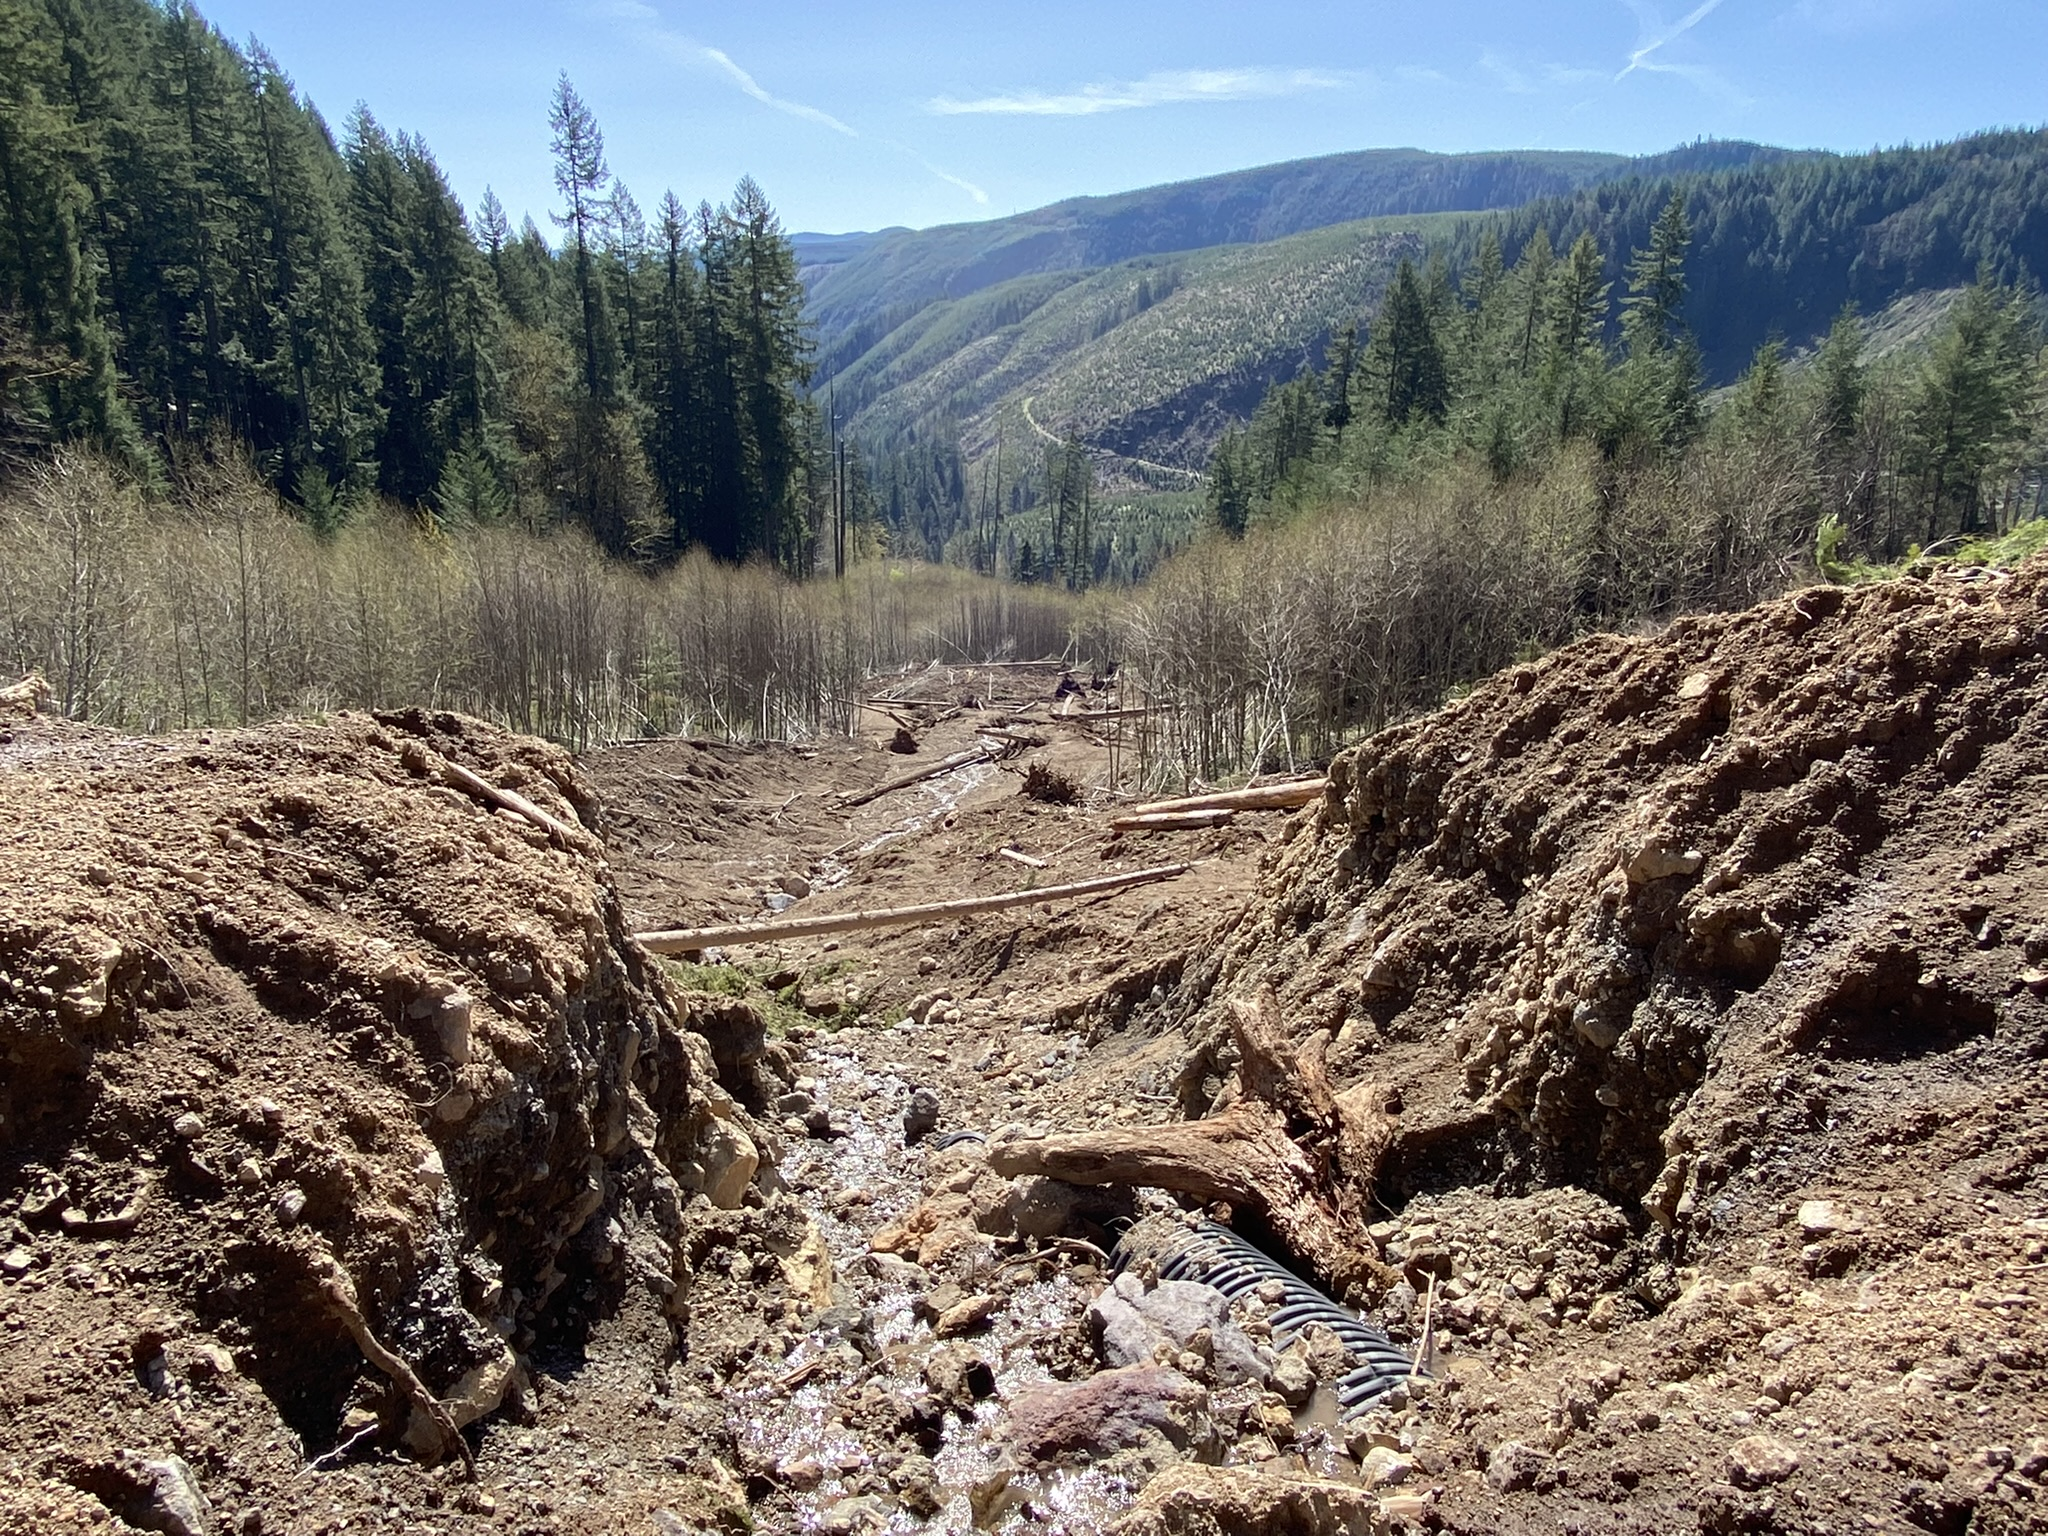
</div> 

## Calibrator overview

The MWR calibration utility uses an adaptive Bayesian Markov chain Monte Carlo (MCMC) algorithm to determine (1) a single set of parameters that best match MWR output to an observed landslide runout dataset and (2) posterior parameter probability distribution functions (PDFs). The observed runout dataset can consist of a single landslide or multiple landslides. To use the calibration utility, the user provides an initial (prior) guess of the parameter values and their respective PDFs that calibrate the MWR to a specific site. Then, the calibration utility randomly selects a set of trial parameter values (Λ) from the prior PDFs and runs MWR using Λ. Once the model has completed the run, the algorithm evaluates the posterior likelihood of the parameter set (L(Λ)) as the product of model ability to replicate observed runout (described below) and the prior likelihood of the parameter set.

<div align="center">
    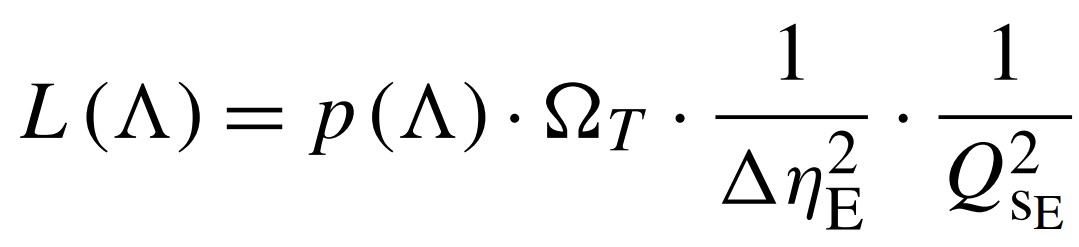
</div>   

Where Ω_T is an index for evaluating model planimetric fit. ∆ηE is the volumetric error of the modeled
topographic change (∆η) over the entire model domain normalized by the observed total mobilized volume (initial landslide
body + erosion volume).The index QsE is the mean error in cumulative sediment transport (Qs) along the modeled runout path
normalized by the observed mean cumulative flow. Details on each metric included in the likelihood function are described in Section 3 of Keck et al. (2024).

After the first L(Λ) has been determined, the utility selects a new set of parameters (Λt+1) by jumping some distance (described below) from each parameter in Λ space. Depending on the value of L(Λt+1), the algorithm either stays at Λ or moves to Λt+1. This Markov process is repeated a user-specified number of times. The jump direction is random, but the algorithm is adaptive because the jump distance changes depending on whether  occurs more than a user-specified threshold value. For a detailed description of the algorithm see Coz et al. (2014). After many jumps, this process produces a unique sampling pattern whose density can be used as emperical estimates of the probabilitly distributions of each sampled parameter. Below and example is shown when S_c and qs_c are used as calibration parameters:

<div align="center">
    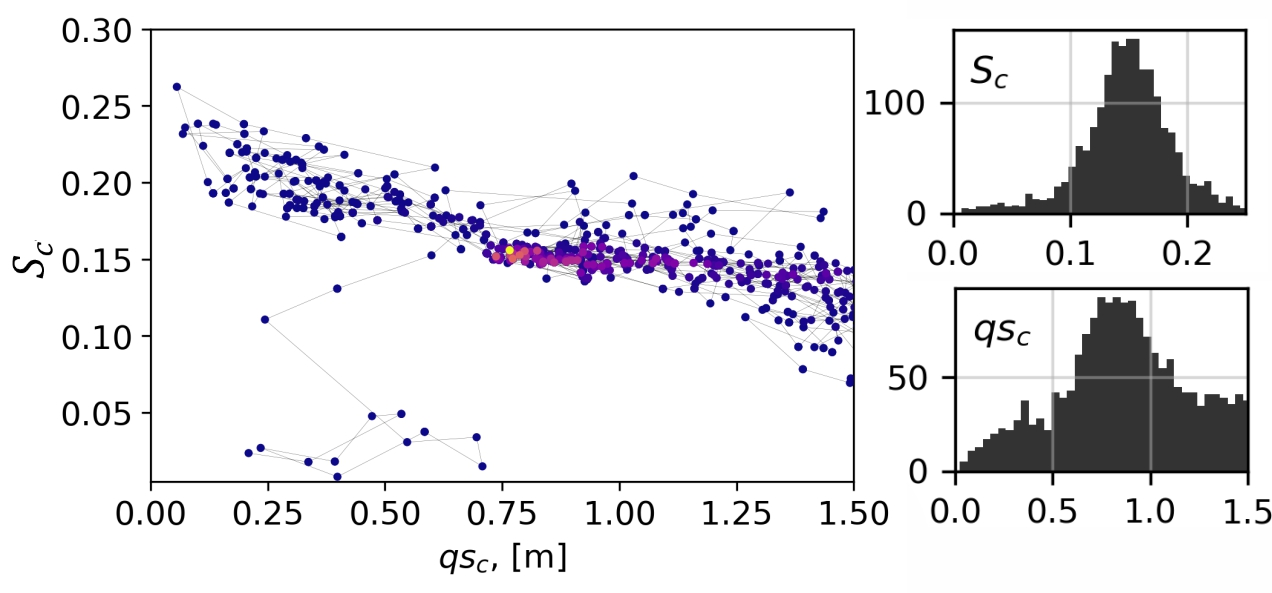
</div>

**To begin, first import  packages and components necessary to load MWR inputs, run MWR and visualize model results.**

In [1]:
## import plotting tools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from IPython.display import HTML

# import pandas and numpy
import pandas as pd
import numpy as np

## import necessary landlab components
from landlab import RasterModelGrid
from landlab.components import(FlowAccumulator,
                                FlowDirectorD8, 
                                FlowDirectorMFD, 
                                DepressionFinderAndRouter)

from landlab.components.mass_wasting_runout import MassWastingRunout

from landlab.components.mass_wasting_runout.MWR_calibrator import (MWR_Calibrator,
                                                                profile_distance,
                                                                profile_plot,
                                                                define_profile_nodes,
                                                                view_profile_nodes,
                                                                plot_MCMC_jumps)

## import landlab plotting functionality
from landlab import imshow_grid_at_node

## import esri ascii read function
from landlab.io import esri_ascii

**Next, define trial MWR parameters S_c, q_c and k and the min and maximum values of prior estimates of their distributions. Also specify key MCMC aglorithm parameters. See comments next to each parameter for explanation**

In [2]:
# Trial model parameters
S_c = [0.156]
q_c = 0.766  # m

# Model parameters, determined from field and DoD
k = 0.0337443
typical_flow_thickness_of_erosion_zone = 2  # m
typical_slope_of_erosion_zone = 0.25
max_flow_depth_observed_in_field = 5  # m
Dp = 0.316  # m

# regolith and runout material attributes that will be tracked
tracked_attributes = ["particle__diameter"]


# calibrator inputs
max_number_of_runs = 7 # number of times MCMC algorithm will iteratively run the model
jump_size = 0.09
alpha_max = 0.7
alpha_min = 0.3#alpha_max-0.4
N_cycles = 100


# parameters for estimating alpha
h = 2
s = 0.25
ros = 2650
vs = 0.6
eta = 0.2

# define the prior estimate of the each parameter's distribution
params = {'qsc':[0.01,1.75,0.3],
          'slpc':[0.005, 0.3, 0.03]} 

# lower and upper extent of elevation range used to evalute Qs profile
el_l = 230
el_h = 430
####

# GIS inputs needed run MWR and MWR calibrator
DEM_pre = "pre_runout_DEM.asc"
DEM_pre_hs = "pre_runout_DEM_hillshade.asc"  # high (2-meter resolution)
lsnodes = "landslide_polygon.asc"  # nodes within the mapped landslide
DoD_o = "DEM_of_Difference.asc"  # observed DEM of difference
ls_depth = "landslide_depth.asc"  # measured depth at each node


**Next, define the initial model terrain and lanslide location and depth.**

To initiate MWR, the user needs to provide an initial DEM, a regolith depth map and the location and depth of the mass wasting source material (e.g., landslide body). In this example, the required inputs have been prepared using an external GIS system. The initial DEM was created after the 2009 landslide but before the 2021 enlargement. Regolith depth is assumed uniform and equal to 1.2 meters. The depth of the landslide was estimated by subtracting a DEM recorded after the 2021 failure from the initial DEM. The landslide polygon was mapped from airphotos of the 2021 landslide and converted to a gridded representation. The number of rows, number of columns and grid size (10 meter) of each input is the same and all are loaded as fields onto a Landlab raster model grid. Below we load each and add them as fields to a raster model grid. We also load a high-resolution hillshade of the model domain that will be used for visualizing model results.

In [3]:
#%% load inputs


# dem
with open(DEM_pre) as fp:
    mg = esri_ascii.load(fp, name="topographic__elevation", at="node")
z = mg.at_node["topographic__elevation"]

# ls nodes
with open(lsnodes) as fp:
    esri_ascii.load(fp, name="mass__wasting_id", at="node", out=mg)
mg.at_node["mass__wasting_id"] = mg.at_node["mass__wasting_id"].astype(int)

# observed DoD
with open(DoD_o) as fp:
    esri_ascii.load(fp, name="DoD_o", at="node", out=mg)

# change null values to zero
mg.at_node["DoD_o"][mg.at_node["DoD_o"] == -9999] = 0

# create a modeled DoD field, to be updated later to show animation of modeled DoD
mg.at_node["DoD_m"] = np.zeros(mg.number_of_nodes)

# soil depth
# here using uniform depth of 1.2 meters
depth = np.ones(mg.number_of_nodes) * 1.2
mg.add_field("soil__thickness", depth, at="node")

# set landslide thickness (depth) equal to measured depth from DEM of Difference
with open(ls_depth) as fp:
    esri_ascii.load(fp, name="ls_depth", at="node", out=mg)

lsd = mg.at_node.pop("ls_depth")
lsd = lsd[lsd != -9999]
mg.at_node["soil__thickness"][mg.at_node["mass__wasting_id"] == 1] = -1 * lsd

# high res hillshade for plot background
with open(DEM_pre_hs) as fp:
    mg_hs = esri_ascii.load(fp, name="hillshade_arc", at="node")
mg_hs.at_node["hillshade_arc"][mg_hs.at_node["hillshade_arc"] == -9999] = np.nan


# landlab built in hillshade
mg.at_node['hillshade'] = mg.calc_hillshade_at_node(elevs=z, alt=37., az=210.)


# finds lowest point in dem and sets it as an open node

mg.set_watershed_boundary_condition(z)

# add particle diameter
# representative grain size of regolith
mg.at_node["particle__diameter"] = np.ones(len(mg.node_x)) * Dp

# flow accumulater to get contributing area to each grid cell. We initially use the FlowDirectorD8 option
# to visualize topographic slope but will replace the flow router with the MFD option later in this notebook
# because MWR uses the multi-directional slope.
fa = FlowAccumulator(mg, "topographic__elevation", flow_director="FlowDirectorD8")
fa.run_one_step()

# fill depressions to correct surface area determination
df_4 = DepressionFinderAndRouter(mg)
df_4.map_depressions()

# save a copy of the initial elevation for dem differencing
_ = mg.add_field(
    "topographic__initial_elevation",
    mg.at_node["topographic__elevation"],
    at="node",
    copy=True,
)

# multiflow direction for MWRu
# need to delete d8 flow direction
mg.delete_field(loc = 'node', name = 'flow__sink_flag')
mg.delete_field(loc = 'node', name = 'flow__link_to_receiver_node')
mg.delete_field(loc = 'node', name = 'flow__receiver_node')
mg.delete_field(loc = 'node', name = 'topographic__steepest_slope')
# run flow director, add slope and receiving node fields
fd = FlowDirectorMFD(mg, diagonals=True,
                      partition_method = 'slope')
fd.run_one_step()

**Before we instantiate and run the model, lets visualize some of the loaded inputs to get a feel for the landslide geometry relative to the terrain.**

First we need to define a few functions for visualizing model results.<br>
These functions are only included in this notebook for visualization and are not necessary to run the model.

In [4]:
def plot_node_field_with_shaded_high_res_dem(
    mg,
    mg_hs,
    field,
    save_name=None,
    plot_name=None,
    figsize=(7, 7),
    cmap="terrain",
    fontsize=10,
    alpha=0.5,
    cbr=None,
    norm=None,
    allow_colorbar=True,
    colorbar_label=None,
    var_name=None,
    var_units=None,
    domain_buffer=0,
    **kwds,
):
    if plot_name is None:
        plt.figure(field, figsize=figsize)
    else:
        plt.figure(plot_name, figsize=figsize)

    mg_hs.imshow(
        "hillshade_arc",
        cmap="Greys_r",
        grid_units=("coordinates", "coordinates"),
        shrink=0.75,
        var_name=None,
        var_units=None,
        output=None,
        allow_colorbar=False,
        color_for_background="white",
        color_for_closed="white",
        limits=(0, 360),
    )
    mg.imshow(
        field,
        cmap=cmap,
        grid_units=("coordinates", "coordinates"),
        shrink=0.75,
        var_name=var_name,
        var_units=var_units,
        alpha=alpha,
        output=None,
        color_for_closed=None,
        color_for_background=None,
        norm=norm,
        allow_colorbar=allow_colorbar,
        colorbar_label=colorbar_label,
    )

    plt.xlim(
        [
            mg.x_of_node[mg.core_nodes].min() - 20,
            mg.x_of_node[mg.core_nodes].max() + domain_buffer,
        ]
    )
    plt.ylim(
        [
            mg.y_of_node[mg.core_nodes].min() - 20,
            mg.y_of_node[mg.core_nodes].max() + domain_buffer,
        ]
    )

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    if cbr is None:
        r_values = mg.at_node[field][mg.core_nodes]
        plt.clim(r_values.min(), r_values.max())
    else:
        plt.clim(cbr[0], cbr[1])

    if save_name is not None:
        plt.savefig(save_name + ".png", dpi=300, bbox_inches="tight")



#### View the 2022 Cascade Mountain landslide body

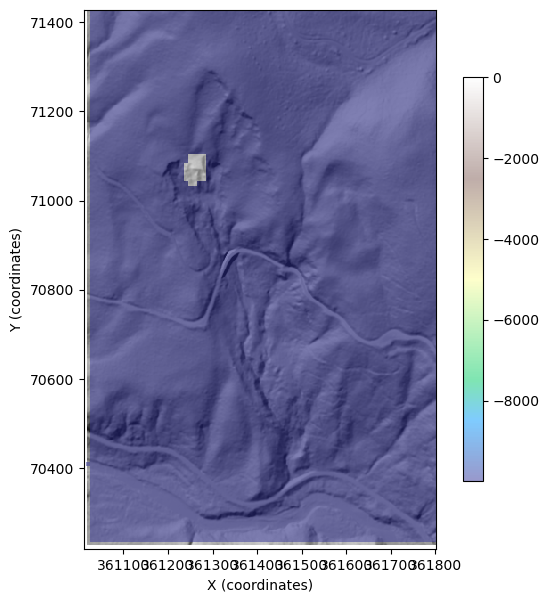

In [5]:
plot_node_field_with_shaded_high_res_dem(mg, mg_hs = mg_hs, field = 'mass__wasting_id',plot_name = 'high_res', fontsize = 10,alpha = .5)

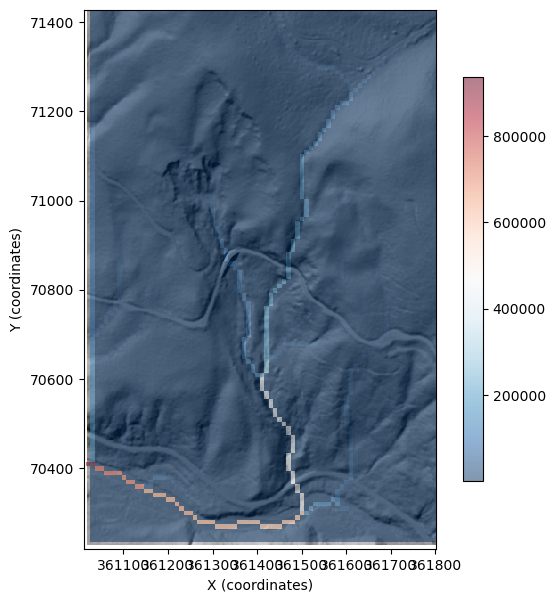

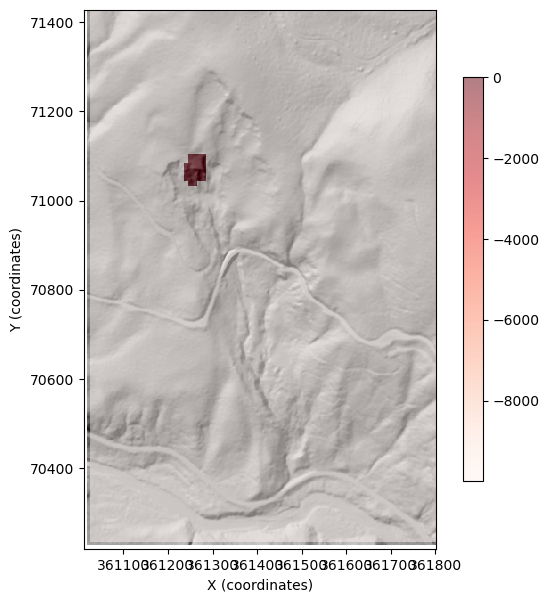

In [6]:
# #%% use DEM to create other needed fields
# # flow accumulater to get contributing area to each grid cell
# fa = FlowAccumulator(mg, 
#                       'topographic__elevation',
#                       flow_director='FlowDirectorD8')
# fa.run_one_step()
# # fill depressions to correct surface area determination
# df_4 = DepressionFinderAndRouter(mg)
# df_4.map_depressions()

# vissually check inputs
plot_node_field_with_shaded_high_res_dem(mg, mg_hs = mg_hs, field = 'drainage_area', fontsize = 10,cmap = 'RdBu_r',alpha = .5)
plot_node_field_with_shaded_high_res_dem(mg, mg_hs = mg_hs, field = 'mass__wasting_id', fontsize = 10,cmap = 'Reds',alpha = .5)



### set model parameters and instantiate MWR!!!!

In [7]:

# set model parameters
MWR = MassWastingRunout(
    grid=mg,
    critical_slope=S_c,
    threshold_flux=q_c,
    erosion_coefficient=k,
    tracked_attributes=tracked_attributes,
    save=True,
    typical_flow_thickness_of_erosion_zone=typical_flow_thickness_of_erosion_zone,
    typical_slope_of_erosion_zone=typical_slope_of_erosion_zone,
    max_flow_depth_observed_in_field=max_flow_depth_observed_in_field,
)


### define the expected runout path. This path will be used to determine Qs over the extent of the runout.

In [8]:
%matplotlib qt 

# the function below opens a separte window that shows the shaded DEM and the landslide location. 
# Click once on the window to begin (ignore error messages), then follow the directions below
runout_profile_nodes, runout_profile_dist, Lxy = define_profile_nodes(mg)


Beginning from the upslope edge of the landslide crown or just upstream of the initial mass wasting
         material, map the centerline of the potential runout path. Use interactive plot to zoom and scroll 
         (right click to zoom out). Move mouse curser, press "space" to add point, "delete" to remove point 
         and "enter" to finish. A profile will be drawn between the points and the nodes that intersect that profile 
         will be designated as profile nodes


In [9]:
# list the ids of the nodes the located along the profile
%matplotlib inline
runout_profile_nodes

array([7142, 7062, 7063, 6983, 6903, 6904, 6824, 6744, 6745, 6665, 6585,
       6586, 6506, 6426, 6427, 6347, 6267, 6268, 6188, 6108, 6028, 5948,
       5868, 5869, 5789, 5709, 5629, 5549, 5469, 5389, 5309, 5310, 5230,
       5231, 5151, 5072, 4992, 4993, 4913, 4914, 4834, 4755, 4675, 4595,
       4515, 4516, 4436, 4356, 4276, 4196, 4197, 4117, 4116, 4036, 3956,
       3876, 3796, 3716, 3636, 3556, 3476, 3396, 3316, 3317, 3237, 3157,
       3158, 3078, 3079, 2999, 2919, 2920, 2840, 2760, 2761, 2681, 2601,
       2602, 2522, 2442, 2443, 2363, 2283, 2284, 2204, 2124, 2125, 2045,
       2046, 1966, 1886, 1887, 1807, 1727, 1647, 1567, 1487, 1488, 1408,
       1328, 1248, 1168, 1088, 1008,  928,  929,  849,  769,  689])

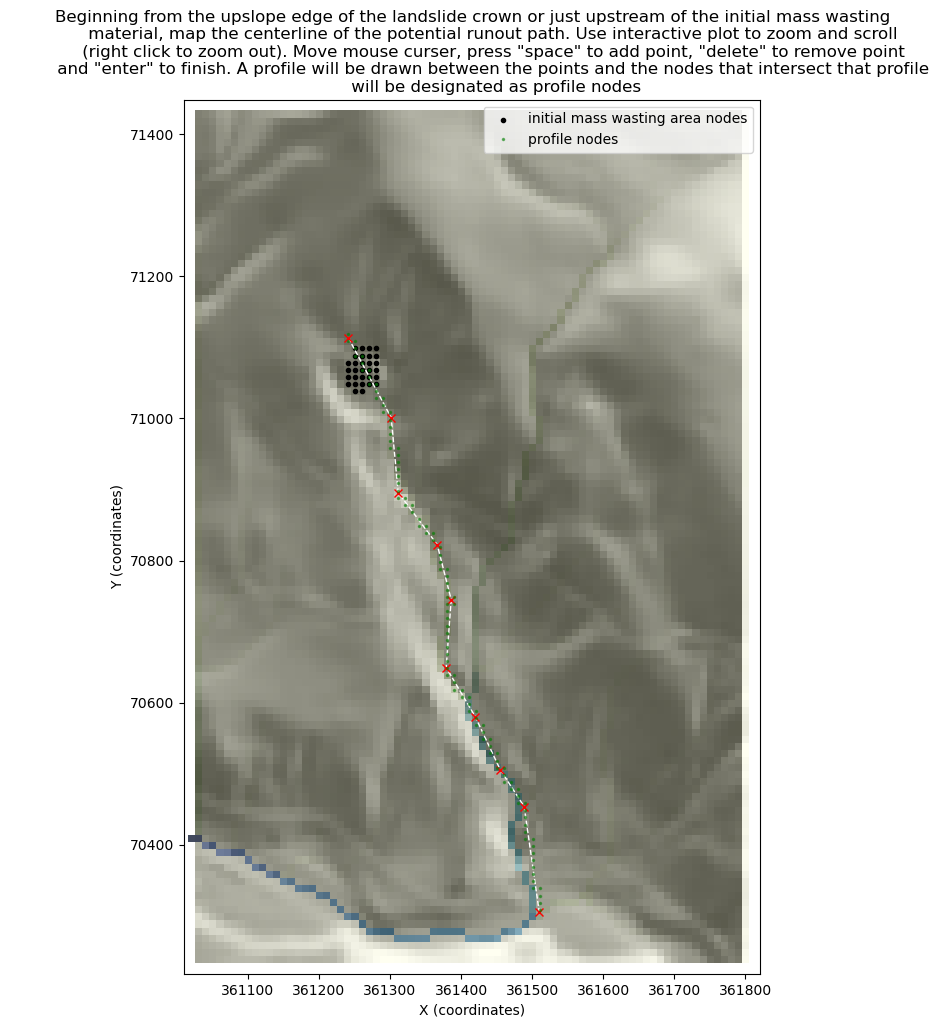

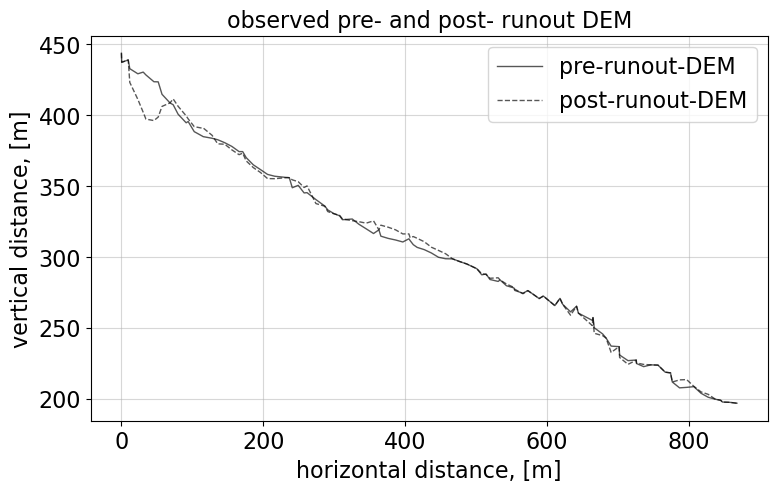

In [10]:
#%% visualize profile and plan view depositional patterns
profile_plot(mg, runout_profile_nodes, runout_profile_dist, aspect = 2,figsize = (12,5), fs = 16)

In [11]:
#%% instantiate the calibration class
calibrator = MWR_Calibrator(MWR, 
                            params, 
                            el_l, 
                            el_h, 
                            runout_profile_nodes, 
                            runout_profile_dist,
                            N_cycles = N_cycles, 
                            prior_distribution = "uniform", 
                            jump_size = jump_size, 
                            alpha_max = alpha_max, 
                            alpha_min=alpha_min, 
                            plot_calibration_metrics = False, 
                            seed = 15,
                            show_progress = True)


In [12]:
#%% calibrate the model 
parameters = calibrator(max_number_of_runs = max_number_of_runs)

MCMC iteration: 0
iteration 1, resampled, qsc>E
MCMC iteration: 5


### plot the parameter values tested by the calibrator

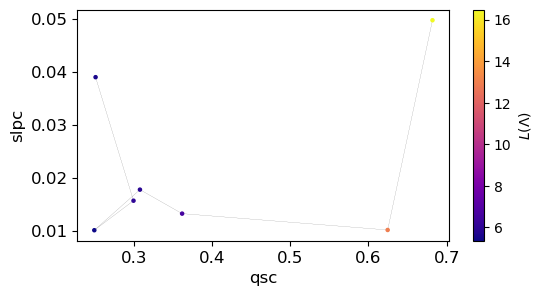

In [13]:
results = calibrator.MCMC_stats
plot_MCMC_jumps(results, 'qsc', 'slpc')

### Make an animation of the MCMC algorithm

C:\ProgramData\miniconda3\envs\landlab_dev\Lib\site-packages\matplotlib\cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


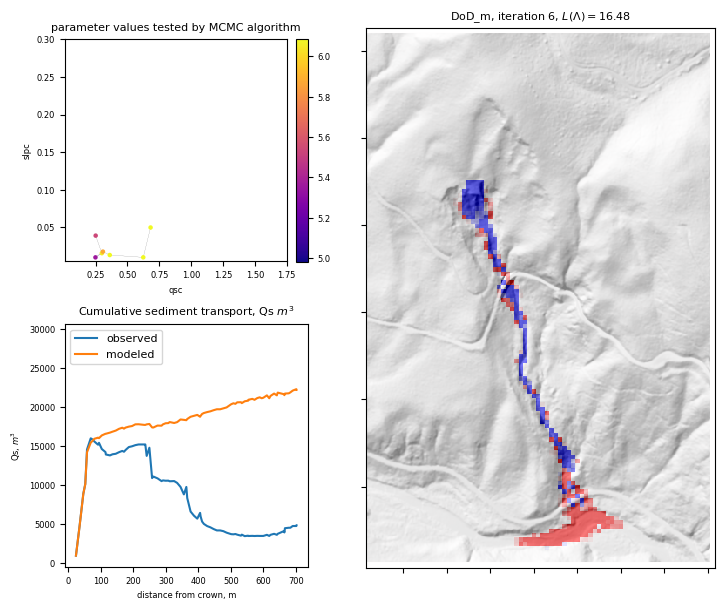

In [14]:


parameter_1 = 'qsc'
parameter_2 = 'slpc'


def get_values_xy(grid, field):
    # convert grid array to input for pcolormesh (from imshow_grid)
    values = grid.at_node[field]
    values = values.reshape(grid.shape)
    y = (
        np.arange(values.shape[0] + 1) * grid.dy
        - grid.dy * 0.5
        + grid.xy_of_lower_left[1]
    )
    x = (
        np.arange(values.shape[1] + 1) * grid.dx
        - grid.dx * 0.5
        + grid.xy_of_lower_left[0]
    )
    return x, y, values


# new plotting function
def color_mesh_vals_subplot(ax, clim=[-1, 1]):
    x, y, values = get_values_xy(mg, "DoD_m")
    myimage = ax.pcolormesh(x, y, values, vmin = clim[0], vmax = clim[1], cmap="bwr", alpha=0.5)
    myimage.set_rasterized(True)
    myimage.axes.set_aspect("equal")
    return myimage

# update function

def update_plot(frame_number, calibrator, myimage, line_o, line_m, results, jump_lines, sc):
    score = calibrator.MCMC_stats['selected_posterior'].iloc[frame_number]
    
    # DoD
    mg.at_node["DoD_m"] = (
        calibrator.DoD_m_dict[frame_number]
    )
    # myimage[0].set_array(mg.at_node["DoD_m"])
    myimage[0].remove()
    # myimage[0] = color_mesh_vals(clim=[-1, 1])
    myimage[0] = color_mesh_vals_subplot(ax3, clim=[-1, 1])
    plt.title(f"DoD_m, iteration {frame_number}, "+r'$L(\Lambda) = {}$'.format(np.round(score,decimals = 2)), fontsize = 8)

    # Qs
    observed = calibrator.mbLdf_o[calibrator.profile_metric] 
    modeled =  calibrator.trial_Qs_profiles[frame_number] 
    line_o.set_data(calibrator.mbLdf_o['runout_profile_distance'], observed)
    line_m.set_data(calibrator.mbLdf_o['runout_profile_distance'], modeled)

    # MCMC jump plot
    x = results['selected_value_{}'.format(parameter_1)].iloc[:frame_number+1], 
    y = results['selected_value_{}'.format(parameter_2)].iloc[:frame_number+1]
    jump_lines.set_data(x, y)
    z = results['candidate_posterior'].iloc[:frame_number+1]
    a = results['selected_value_{}'.format(parameter_1)].iloc[:frame_number+1].values
    b = results['selected_value_{}'.format(parameter_2)].iloc[:frame_number+1].values
    sc.set_offsets(np.array([a,b]).T)
    sc.set_array(z)
    
    return myimage#, line_o, line_m, 


# prepare the first frame
fig = plt.figure(figsize=(7.7, 6))

# Define a 2x2 grid
# height_ratios=[1, 2] makes the bottom row twice as tall as the top
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[0.65, 1],
                       wspace=0.15, hspace=0.205, top=0.95, bottom=0.05, left=0.09, right=0.95)

ax1 = fig.add_subplot(gs[0, 0]) # Top Rectangular
ax2 = fig.add_subplot(gs[1, 0]) # Bottom Square 1
ax3 = fig.add_subplot(gs[:, 1]) # Bottom Square 2

# control aspect of bottom two plots
ax1.set_box_aspect(1)
ax2.set_box_aspect(1) 
ax3.set_box_aspect(1.55)

# add the data

# DoD
nmax = len(calibrator.DoD_m_dict.keys())
x, y, values = get_values_xy(mg_hs, "hillshade_arc")
myimage = ax3.pcolormesh(x, y, values, cmap="Greys_r", alpha=1)
myimage.set_rasterized(True)
myimage.axes.set_aspect("equal")
ax3.autoscale(tight=True)
ax3.xaxis.set_tick_params(labelbottom=False)
ax3.yaxis.set_tick_params(labelleft=False)
myimage = [color_mesh_vals_subplot(ax3, clim=[-1, 1])]


# Qs plot
observed = calibrator.mbLdf_o[calibrator.profile_metric] 
modeled =  calibrator.trial_Qs_profiles[0] 
line_o, = ax2.plot(calibrator.mbLdf_o['runout_profile_distance'], observed, label = 'observed')
line_m, = ax2.plot(calibrator.mbLdf_o['runout_profile_distance'], modeled, label = 'modeled')
ax2.tick_params(axis = 'both', which = 'major', labelsize = 6)
ax2.set_ylabel('Qs, $m^3$', fontsize = 6)
ax2.set_xlabel('distance from crown, m', fontsize = 6)
ax2.legend(loc = 'upper left', fontsize = 8)
ax2.set_title('Cumulative sediment transport, Qs $m^3$', fontsize = 8)


# MCMC jump plot
frame_number = 0
jump_lines, = ax1.plot(results['selected_value_{}'.format(parameter_1)][:frame_number+1], results['selected_value_{}'.format(parameter_2)][:frame_number+1], 
                  linestyle = '-', color = 'k',
                  alpha = 0.75, linewidth = 0.1,zorder=0)
z = results['candidate_posterior'][:frame_number+1]
sc = ax1.scatter(results['selected_value_{}'.format(parameter_1)][:frame_number+1], results['selected_value_{}'.format(parameter_2)][:frame_number+1], c=z, s=5, cmap="plasma", alpha = 1,zorder=10)

ax1.set_xlabel('{}'.format(parameter_1), fontsize = 6)
ax1.set_ylabel('{}'.format(parameter_2), fontsize = 6)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 6)
cbar = fig.colorbar(sc, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_xlim(calibrator.params[parameter_1][0], calibrator.params[parameter_1][1])
ax1.set_ylim(calibrator.params[parameter_2][0], calibrator.params[parameter_2][1])
ax1.set_title('parameter values tested by MCMC algorithm', fontsize = 8)
cbar.ax.tick_params(labelsize = 6)


animate = animation.FuncAnimation(
    fig,
    update_plot,
    nmax,
    fargs=(calibrator, myimage, line_o, line_m, results, jump_lines, sc),
    blit=True,
    repeat=True,
    cache_frame_data=False,
)

HTML(animate.to_jshtml())